In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
price = clean_up_columns(data)
data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='mean')
vol = clean_up_columns(data)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  app.launch_new_instance()


In [3]:
qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
markets=pd.read_csv('contracts.csv',index_col=0)
volume=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='sum')
fx=pd.read_csv('currency.csv',index_col=0,parse_dates=['DATE'])

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()


In [4]:
df=pd.DataFrame()
df=price.copy()
for x in qd.columns:
    df[x]=qd[x]

# Correlation approach to clense data
Use pairwise correlation in order to decide which which markets are duplicates then use the one with the longer history. 

In [5]:
# Function to give list of correlations above a certain amount
def pair_correlation(df,level):
    corr=df.resample(rule='m',how='last').corr()
    pairs=[]
    for mkt in df.T.T.columns:
        ans= corr[mkt].sort_values().tail().head(4) >level
        if ans[ans].count() ==1:
            if mkt != ans[ans].index[0]:
                pairs.append([mkt,ans[ans].index[0]])
        elif ans[ans].count() ==0:
            continue
        else:
            print ans[ans]
    return pairs

In [6]:
# Function to seperate which has longer data.  takes a list of list
def longer_list(pairs):
    more =[]
    less =[]
    for x,y in pairs:
        if x == y:
            continue
        mkt1 =df[x].resample(rule='m',how='last').count()
        mkt2 =df[y].resample(rule='m',how='last').count()
        if mkt1>mkt2:
            more.append(x)
            less.append(y)
        else:
            more.append(y)
            less.append(x)        
    return more, less

In [7]:
pairs = pair_correlation(df,.995)

ICE-BRENT CRUDE OIL    True
ICE-GAS OIL            True
Name: NYM-NY HARBOR ULSD, dtype: bool
NYM-NY HARBOR ULSD    True
ICE-GAS OIL           True
Name: ICE-BRENT CRUDE OIL, dtype: bool
ICE-BRENT CRUDE OIL    True
NYM-NY HARBOR ULSD     True
Name: ICE-GAS OIL, dtype: bool


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


In [8]:
more , less = longer_list(pairs)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [9]:
for p in pairs:
    aa=pd.DataFrame()
    aa=df[p][:'2016']
    x,y=p
    #if x in less:
    #    aa.resample(rule='m',how='last').dropna(how='all').plot(title=p[0],colormap='jet')

In [43]:
cleansed = df.copy()
for rm_mkt in set(less):
    try:
        cleansed.drop(rm_mkt, axis=1, inplace=True)
    except:
        print rm_mkt
        
data = cleansed.resample(rule='m').last()[:'2016']
cleansed=cleansed.T[data.count()>48].T

In [44]:
len(pairs)

32

In [45]:
df.count().count()

198

In [46]:
cleansed.count().count()

145

In [35]:
c=cleansed[:'2016'].tail(1).T.columns

In [36]:
cleansed[:'2016'].resample(rule='m').pct_change().cumsum().tail(1).T[c[0]].sort_values().dropna().head()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


Singapore 380   -0.822686
Singapore 180   -0.809806
BRL/USD         -0.703773
SHFE-BITUMEN    -0.616210
Termal Coal     -0.554612
Name: 2016-12-31 00:00:00, dtype: float64

In [37]:
def tsmom_improved2(data,months):
    vol=pd.ewmstd(data.pct_change(),250)*math.sqrt(12)
    data = data.resample(rule='m',how='last')
    signal=data/data.shift(months)-1
    signal = signal /abs(signal)
    position=signal / vol 
    return position

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=250).std(bias=False)
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


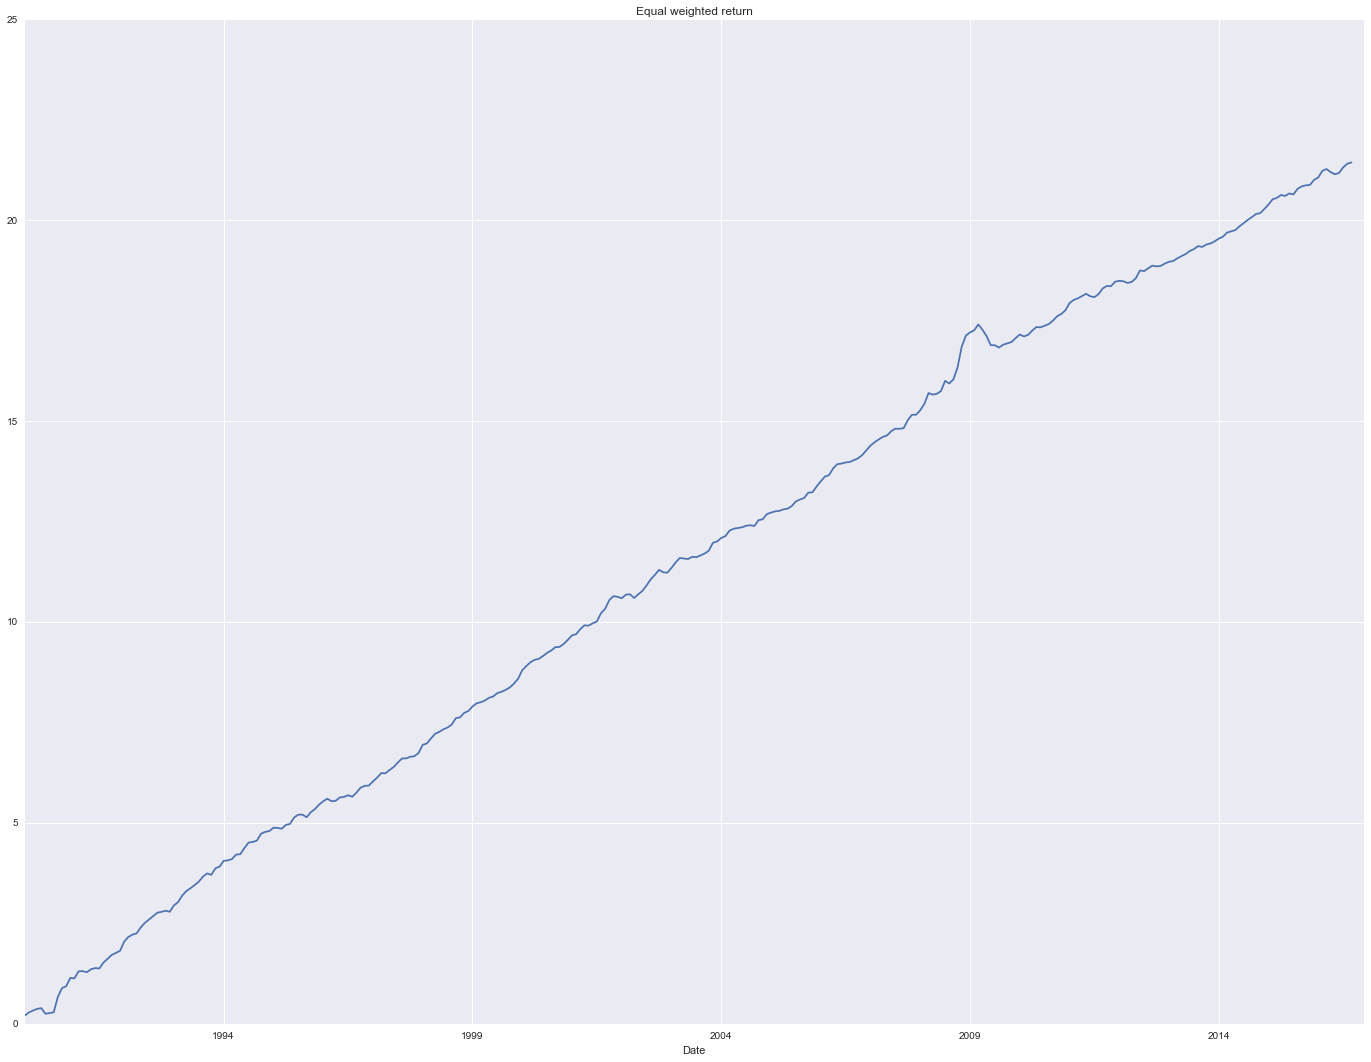

In [38]:
#from tsmom_model import *
data = cleansed.resample(rule='m').last()[:'2016']
pos=tsmom_improved2(data,12)
pnl=calc_pnl(pos,data)
sr=calc_Sharpe(pnl)
ew_portfolio_pnl(pnl)['1990':'2016'].cumsum().plot(title='Equal weighted return')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


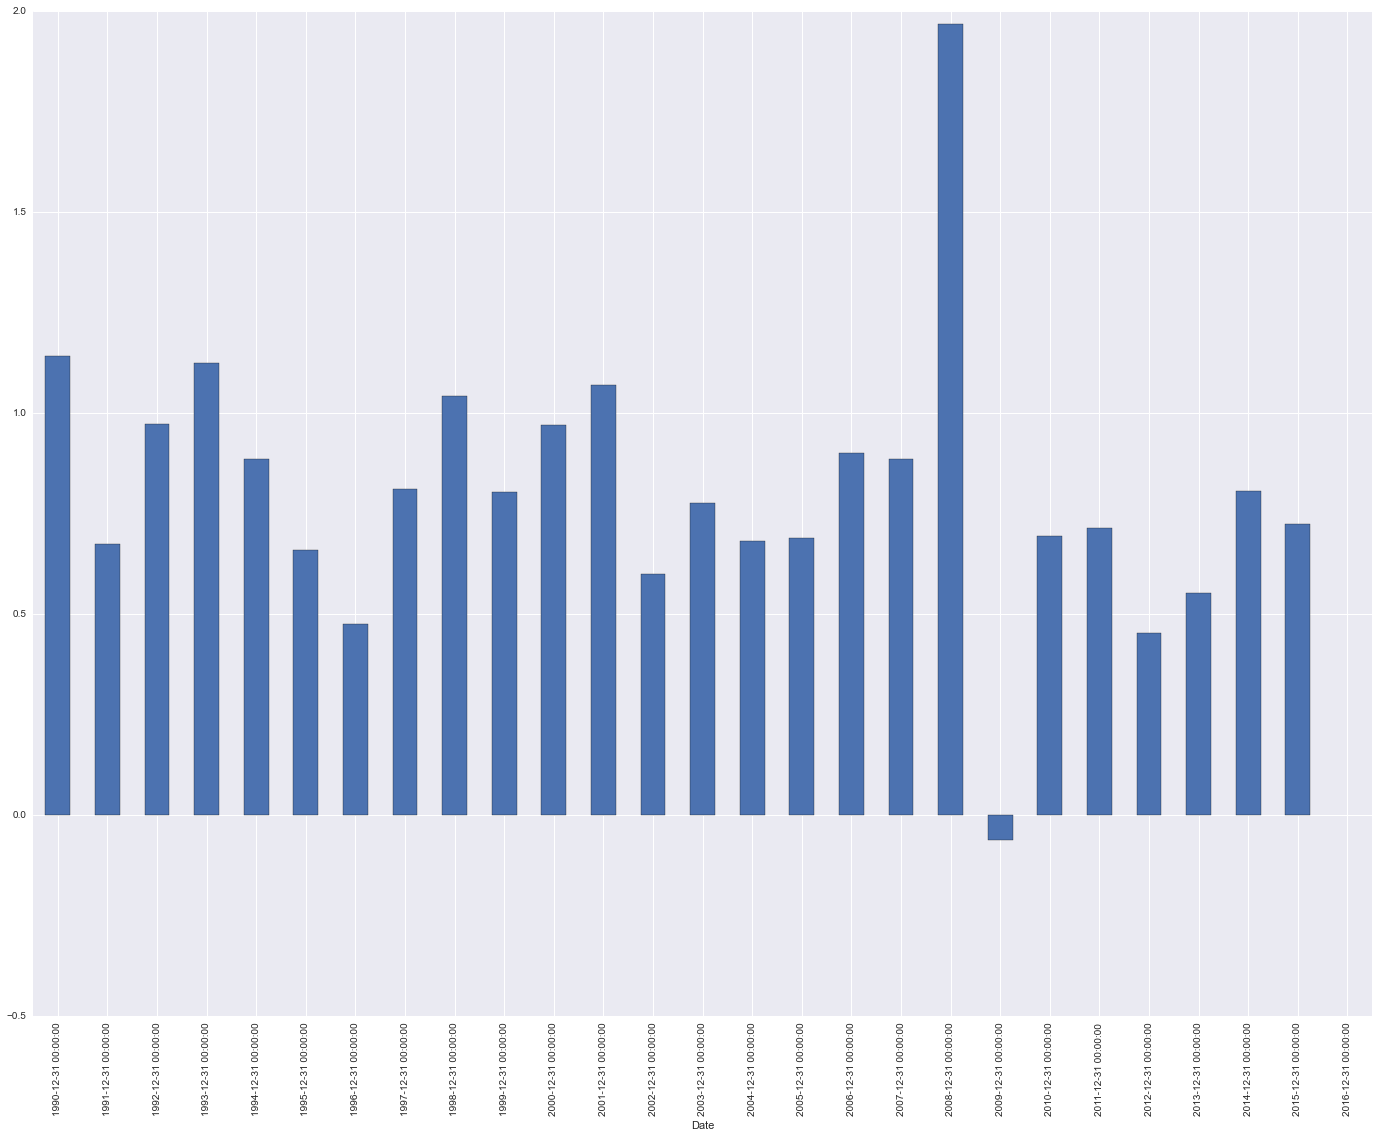

In [39]:
ew_portfolio_pnl(pnl)['1990':'2016'].resample(rule='a',how='sum').plot(kind='bar')

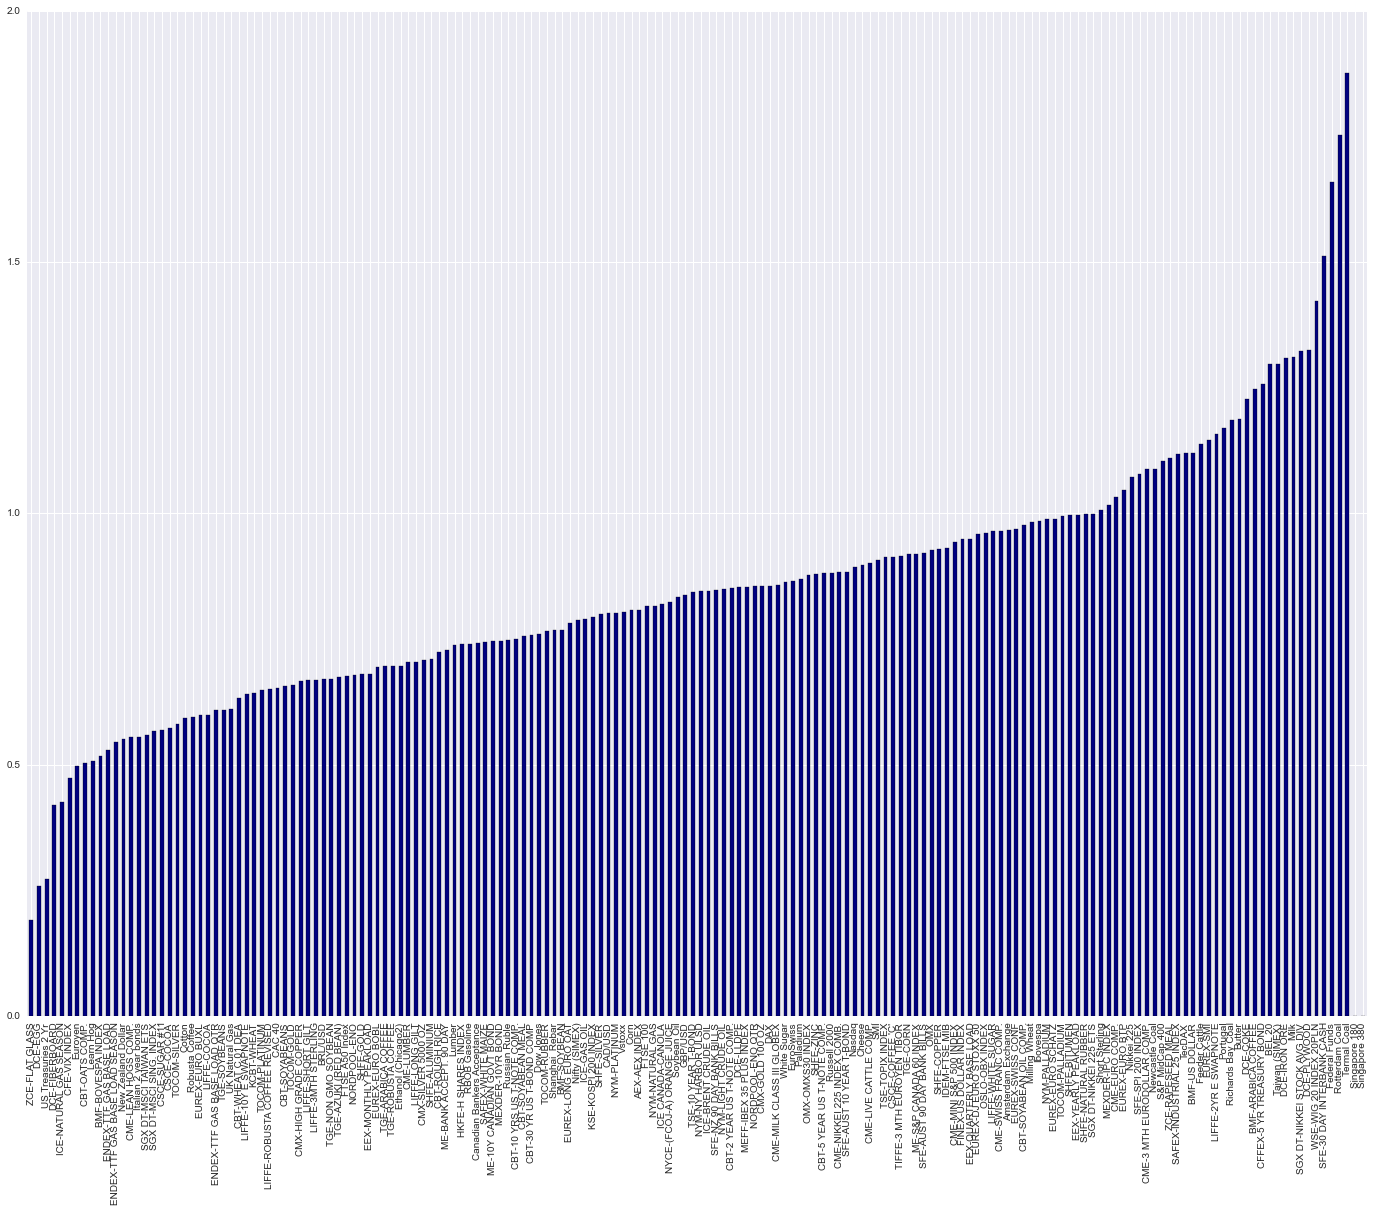

In [41]:
sr.sort_values().plot(kind='bar',colormap='jet')